# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), evaluating your model's results (task 3), and describing the contributions of each team member (task 4).

For grading, please make sure your notebook has all cells already run. You will also need to write a short, 2 page report about your design decisions as a team, to be uploaded to Moodle in the form of a PDF file next to this Jupyter notebook.

You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [1]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

DATA_DIR = './data' # You many change the directory

# Your code goes here

## Task 0: Research Question

**Research question:**

*Predict users performance based on their activity behaviour*

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

In [2]:
# Your code for data processing goes here

### Here call your scripts for preprocessing, also explain the preprocessing steps that you did in general + data loss + graphs 

activity = pd.read_csv('{}/features/activity.csv'.format(DATA_DIR))
performances = pd.read_csv('{}/features/performances.csv'.format(DATA_DIR))

**Comment:** Unfortunately, many of the data points are not useable as our main method relies on looking at the behaviour of the students and therefore the time spent on activities is important to us. In the following graph we can see the ammount of activity data that is of length 0. (see annexe for trials of using the unuseable data)

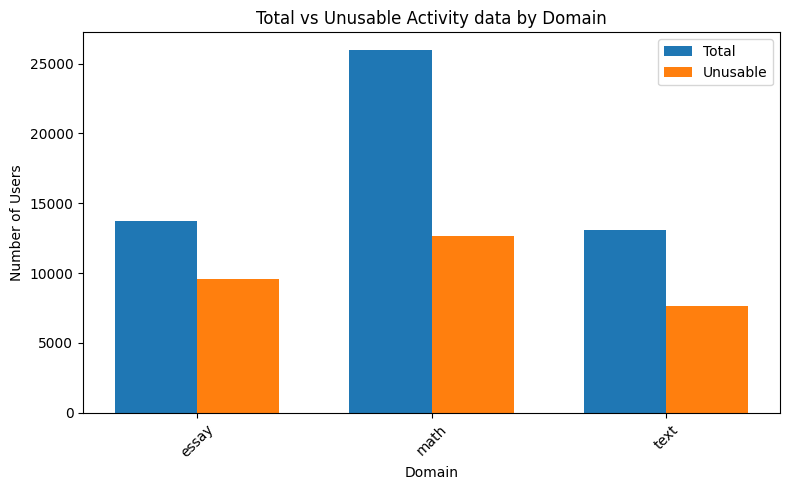

In [3]:
total = activity.groupby('domain')['user_id'].count()
unuseable = activity[activity['activity_completed'].isna()]
unuseable_count = unuseable.groupby('domain')['user_id'].count()

domains = sorted(set(total.index).union(set(unuseable_count.index)))
total = total.reindex(domains, fill_value=0)
unuseable_count = unuseable_count.reindex(domains, fill_value=0)

x = np.arange(len(domains))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, total, width, label='Total')
plt.bar(x + width/2, unuseable_count, width, label='Unusable')

plt.ylabel('Number of Users')
plt.xlabel('Domain')
plt.title('Total vs Unusable Activity data by Domain')
plt.xticks(x, domains, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
print(f'By deleting these colums, we lose {(unuseable_count.sum()/total.sum() * 100).round(2)} % of the initial data ...')

By deleting these colums, we lose 56.67 % of the initial data ...


In [5]:
activity.dropna(inplace=True)

**Comment:** This is quite a big loss of data but a necessary one... (see annexe for trial without this loss of data)

### Feature engineering 

**Our aim is to predict a user's score on their first attempt at a specific exam, based on their behavior leading up to it. To train our model, we engineered the following features to capture and characterize user behavior:**

- recent_avg_time_per_activity

*The average time (in minutes) spent per activity during the last 10 days before the exam, including the exam day. This reflects how intensely the user has been engaging recently.*

- days_since_last_activity

*The number of days between the user's most recent activity and the exam. A higher value may indicate a longer gap in studying before the exam.*

- total_time_spent_on_activity_before_exam

*The total amount of time (in minutes) the user spent on activities prior to the exam. This gives a sense of overall study investment leading up to the test.*

- average_performance_past_exams

*The mean performance from the user's previous exams (before this one). This can provide a rough estimate of the user's historical performance.*

- avg_activities_per_day_recent

*The average number of activities completed per day in the 10-day rolling window. A higher number may suggest more consistent or intense preparation.*

- active_days_ratio_recent

*The proportion of days (out of 10) on which the user was active. This indicates how regularly they studied leading up to the exam.*

- diversity_recent

*The number of unique activity types completed in the rolling window. Higher diversity could reflect more varied engagement with different learning methods or content types.*


In [6]:
# Rolling window for recent activity
rolling_window_days = 10


def compute_all_features_for_exam(exam_row, user_activities, user_exams, window_days=rolling_window_days):

    exam_dt = exam_row['time']


    # Include activities up to and including exam_date
    previous_activities = user_activities[user_activities['activity_updated'] < exam_dt].copy()


    # Rolling window (activities in the last N days, including exam day)
    window_start = exam_dt - pd.Timedelta(days=window_days)
    rolling_activities = previous_activities[previous_activities['activity_updated'] >= window_start].copy()

    features = {}


    # Recent average time per activity (rolling window)
    total_time_rolling = rolling_activities['time_in_minutes'].sum()
    count_rolling = len(rolling_activities)
    features['recent_avg_time_per_activity'] = total_time_rolling / count_rolling if count_rolling > 0 else 0


    # Number of days since last activity
    if not previous_activities.empty:
        last_activity_date = previous_activities['activity_updated'].max()
        features['days_since_last_activity'] = (exam_dt - last_activity_date).days
    else:
        features['days_since_last_activity'] = np.nan


    # Total time spent on activities before the exam
    features['total_time_spent_on_activity_before_exam'] = previous_activities['time_in_minutes'].sum() if not previous_activities.empty else 0


    # Average performance on past exams
    previous_exams = user_exams[user_exams['time'] < exam_dt]
    features['average_performance_past_exams'] = previous_exams['performance'].mean() if not previous_exams.empty else np.nan ###### HERE WE NEED TO FIX


    # Usage Frequency: Average activities per day in rolling window & Active days ratio
    features['avg_activities_per_day_recent'] = count_rolling / window_days if window_days > 0 else np.nan
    if not rolling_activities.empty:
        distinct_days = rolling_activities['activity_updated'].dt.normalize().nunique()
    else:
        distinct_days = 0
    features['active_days_ratio_recent'] = distinct_days / window_days if window_days > 0 else np.nan


    # Activity diversity (rolling window)
    features['diversity_recent'] = rolling_activities['activity_type'].nunique() if not rolling_activities.empty else 0


    return pd.Series(features)


**All features are calculated separately within each domain — Math, Text, and Essay — to capture domain-specific learning patterns and engagement.**

We have also scaled the features using a standard because we assume a normal distribution

In [7]:
scaler = StandardScaler()
columns_to_scale = ['recent_avg_time_per_activity', 'days_since_last_activity', 'total_time_spent_on_activity_before_exam','average_performance_past_exams','avg_activities_per_day_recent','diversity_recent']

#### Math data 

In [8]:
performances_math = performances[performances['domain']== 'math'].copy()
activity_math = activity[activity['domain']== 'math'].copy()

# Convert the 'date' columns to datetime
activity_math['activity_updated'] = pd.to_datetime(activity_math['activity_updated'])
performances_math['time'] = pd.to_datetime(performances_math['time'])

# Loop over each exam (grouped by user) in performances_math and compute all features.
features_list = []

for user_id, user_exams in performances_math.groupby('user_id'):
    # Get corresponding activities for the user from activity_math and sort by date
    user_activities = activity_math[activity_math['user_id'] == user_id].sort_values('activity_updated')
    user_exams_sorted = user_exams.sort_values('time')

    for exam_index, exam_row in user_exams_sorted.iterrows():
        feats = compute_all_features_for_exam(exam_row, user_activities, user_exams_sorted, rolling_window_days)
        feats['exam_index'] = exam_index
        features_list.append(feats)

# Output df
features_df = pd.DataFrame(features_list).set_index('exam_index')
performances_math_features = performances_math.join(features_df, how='left')


# scaling the columns
scaled_values = scaler.fit_transform(performances_math_features[columns_to_scale])
scaled_df = pd.DataFrame(scaled_values, columns=columns_to_scale, index=performances_math_features.index)
remaining_df = performances_math_features.drop(columns=columns_to_scale)
final_df_math = pd.concat([scaled_df, remaining_df], axis=1)

In [9]:
final_df_math.isnull().sum()

recent_avg_time_per_activity                  0
days_since_last_activity                     56
total_time_spent_on_activity_before_exam      0
average_performance_past_exams              469
avg_activities_per_day_recent                 0
diversity_recent                              0
user_id                                       0
domain                                        0
test_id                                       0
course                                        0
date                                          0
time                                          0
percentage                                    0
performance                                   0
active_days_ratio_recent                      0
dtype: int64

In [10]:
print('Total Nb of rows :', final_df_math.user_id.count())
print('Nb of rows where we are missing feature values :', final_df_math.isna().any(axis=1).sum())
print('Percentage of rows where we are missing feature values :', final_df_math.isna().any(axis=1).sum()/ final_df_math.user_id.count() * 100)

Total Nb of rows : 3810
Nb of rows where we are missing feature values : 470
Percentage of rows where we are missing feature values : 12.335958005249344


**Comment:** Some features for some rows cannot be computed. This occurs especially for the "average_performance_past_exams" feature, which correspond to the first exam questions that every user did for which there is no past value. We will first try to train a linear model by dropping these rows and then we will try to impute these values with the average exam percentage of similar users and see which model performs best. 

**Comment:** For the math data, the loss of 12% is negligeable and this should not effect the model too much seeing we still have around 3400 data points

#### Essay data

In [11]:
performances_essay = performances[performances['domain']== 'essay'].copy()
activity_essay= activity[activity['domain']== 'essay'].copy()

# Convert the date columns  to datetime
activity_essay['activity_updated'] = pd.to_datetime(activity_essay['activity_updated'])
performances_essay['time'] = pd.to_datetime(performances_essay['time'])

# Loop over each exam (grouped by user) in performances_essay and compute all features.
features_list = []

for user_id, user_exams in performances_essay.groupby('user_id'):
    # Get corresponding activities for the user from activity_essay and sort by date
    user_activities = activity_essay[activity_essay['user_id'] == user_id].sort_values('date')
    user_exams_sorted = user_exams.sort_values('date')

    for exam_index, exam_row in user_exams_sorted.iterrows():
        feats = compute_all_features_for_exam(exam_row, user_activities, user_exams_sorted, rolling_window_days)
        feats['exam_index'] = exam_index
        features_list.append(feats)

# Output df
features_df = pd.DataFrame(features_list).set_index('exam_index')
performances_essay_features = performances_essay.join(features_df, how='left')


# scaling the columns
scaled_values = scaler.fit_transform(performances_essay_features[columns_to_scale])
scaled_df = pd.DataFrame(scaled_values, columns=columns_to_scale, index=performances_essay_features.index)
remaining_df = performances_essay_features.drop(columns=columns_to_scale)
final_df_essay = pd.concat([scaled_df, remaining_df], axis=1)

In [12]:
final_df_essay.isnull().sum()

recent_avg_time_per_activity                  0
days_since_last_activity                    193
total_time_spent_on_activity_before_exam      0
average_performance_past_exams              308
avg_activities_per_day_recent                 0
diversity_recent                              0
user_id                                       0
domain                                        0
test_id                                       0
course                                        0
date                                          0
time                                          0
percentage                                    0
performance                                   0
active_days_ratio_recent                      0
dtype: int64

In [13]:
print('Total Nb of rows :', final_df_essay.user_id.count())
print('Nb of rows where we are missing feature values :', final_df_essay.isna().any(axis=1).sum())
print('Percentage of rows where we are missing feature values :', final_df_essay.isna().any(axis=1).sum()/ final_df_essay.user_id.count() * 100)

Total Nb of rows : 581
Nb of rows where we are missing feature values : 361
Percentage of rows where we are missing feature values : 62.1342512908778


**Comment:** Unfortunately, there is not a lot of data available to us for the essay domain. Only 581 rows can be used to train our model, which is not enough.

**Comment:** For the essay data, the loss of 63% of the data is not as negligeable as with the math data. Here, we will only be left with around 220 data points, which will make it complicated for the model to perform well... 

#### Text data 

In [14]:
performances_text = performances[performances['domain']== 'text'].copy()
activity_text= activity[activity['domain']== 'text'].copy()

# Convert the date columns to datetime
activity_text['activity_updated'] = pd.to_datetime(activity_text['activity_updated'])
performances_text['time'] = pd.to_datetime(performances_text['time'])

# Loop over each exam (grouped by user) in performances_text and compute all features.
features_list = []

for user_id, user_exams in performances_text.groupby('user_id'):
    # Get corresponding activities for the user from activity_text and sort by date
    user_activities = activity_text[activity_text['user_id'] == user_id].sort_values('date')
    user_exams_sorted = user_exams.sort_values('date')

    for exam_index, exam_row in user_exams_sorted.iterrows():
        feats = compute_all_features_for_exam(exam_row, user_activities, user_exams_sorted, rolling_window_days)
        feats['exam_index'] = exam_index
        features_list.append(feats)

# Output df
features_df = pd.DataFrame(features_list).set_index('exam_index')
performances_text_features = performances_text.join(features_df, how='left')


# Scale the columns
scaled_values = scaler.fit_transform(performances_text_features[columns_to_scale])
scaled_df = pd.DataFrame(scaled_values, columns=columns_to_scale, index=performances_text_features.index)
remaining_df = performances_text_features.drop(columns=columns_to_scale)
final_df_text = pd.concat([scaled_df, remaining_df], axis=1)

In [15]:
final_df_text.isnull().sum()

recent_avg_time_per_activity                  0
days_since_last_activity                    307
total_time_spent_on_activity_before_exam      0
average_performance_past_exams              122
avg_activities_per_day_recent                 0
diversity_recent                              0
user_id                                       0
domain                                        0
test_id                                       0
course                                        0
date                                          0
time                                          0
percentage                                    0
performance                                   0
active_days_ratio_recent                      0
dtype: int64

In [16]:
print('Total Nb of rows :', final_df_text.user_id.count())
print('Nb of rows where we are missing feature values :', final_df_text.isna().any(axis=1).sum())
print('Percentage of rows where we are missing feature values :', final_df_text.isna().any(axis=1).sum()/ final_df_text.user_id.count() * 100)

Total Nb of rows : 445
Nb of rows where we are missing feature values : 356
Percentage of rows where we are missing feature values : 80.0


**Comment:** Unfortunately, there is even less data available for the text domain. Only 445 rows can be used to train our model, which is again not enough.

**Comment:** For the text data, the loss of803% of the data is not as negligeable as with the math data. Here, we will only be left with around 90 data points, which will make it complicated for the model to perform well... 

*Your discussion about your processing decisions goes here*


HERE ADD SOME COMMENTS

## Task 2: Model Building

Train a model for your research question. 

**Comment:** Seeing the lack of data available to us for both the text and essay domains, we decided to concentrate on the math data for the following parts 

### Method 0 : Simple Linear Regression where we drop NAN

In [17]:
# Your code for training a model goes here

final_df_math_drop = final_df_math.copy()
final_df_math_drop.dropna(inplace=True)



# Linear Regression Model
mod_method0 = smf.ols(formula='performance ~  recent_avg_time_per_activity + days_since_last_activity + total_time_spent_on_activity_before_exam + average_performance_past_exams + avg_activities_per_day_recent + diversity_recent', data=final_df_math_drop)
# Fit the model
res_method0 = mod_method0.fit()
# Print regression results summary
print(res_method0.summary())

                            OLS Regression Results                            
Dep. Variable:            performance   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     202.1
Date:                Fri, 25 Apr 2025   Prob (F-statistic):          2.41e-220
Time:                        15:59:12   Log-Likelihood:                -15422.
No. Observations:                3340   AIC:                         3.086e+04
Df Residuals:                    3333   BIC:                         3.090e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [18]:
# final_df_essay_drop = final_df_essay.copy()
# final_df_essay_drop.dropna(inplace=True)

# # Linear Regression Model
# mod_essay = smf.ols(formula='performance ~  recent_avg_time_per_activity + days_since_last_activity + total_time_spent_on_activity_before_exam + average_performance_past_exams + avg_activities_per_day_recent + diversity_recent', data=final_df_essay_drop)
# # Fit the model
# res_essay = mod_essay.fit()
# # Print regression results summary
# print(res_essay.summary())

In [19]:
# final_df_text_drop = final_df_text.copy()
# final_df_text_drop.dropna(inplace=True)

# # Linear Regression Model
# mod_text = smf.ols(formula='performance ~  recent_avg_time_per_activity + days_since_last_activity + total_time_spent_on_activity_before_exam + average_performance_past_exams + avg_activities_per_day_recent + diversity_recent', data=final_df_text_drop)
# # Fit the model
# res_text = mod_text.fit()
# # Print regression results summary
# print(res_text.summary())

### Method 1 : Mixed Effects Linear Regression where we drop NAN and cluster the users 

Add explanation here

In [20]:
# Collapse to one row per user for clustering
user_feats = final_df_math_drop.groupby('user_id')[['recent_avg_time_per_activity', 'days_since_last_activity', 'total_time_spent_on_activity_before_exam', 'average_performance_past_exams', 'avg_activities_per_day_recent', 'active_days_ratio_recent', 'diversity_recent']].mean().reset_index()

# Cluster into 3 groups
kmeans = KMeans(n_clusters=3, random_state=0)
user_feats['cluster'] = kmeans.fit_predict(user_feats.drop(columns='user_id'))

# Merge cluster label back into final_df
df2 = final_df_math_drop.merge(user_feats[['user_id','cluster']], on='user_id')

# Fit a mixed‐effects model with random intercept per cluster
md = smf.mixedlm("performance ~ recent_avg_time_per_activity + days_since_last_activity + \
     total_time_spent_on_activity_before_exam + average_performance_past_exams + \
     avg_activities_per_day_recent + active_days_ratio_recent + diversity_recent",df2,groups="cluster")
mdf = md.fit(reml=False)
print(mdf.summary())

# In-sample predictions
df2["pred_cluster"] = mdf.predict(df2)

# Compute R² and RMSE
r2_cluster = r2_score(df2["performance"], df2["pred_cluster"])
rmse_cluster = mean_squared_error(df2["performance"], df2["pred_cluster"])

print("Cluster‐model  AIC:",  mdf.aic, "  BIC:", mdf.bic)
print(f"Cluster‐model  R² = {r2_cluster:.3f},  RMSE = {rmse_cluster:.3f}")

                       Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         performance
No. Observations:           3340            Method:                     ML         
No. Groups:                 3               Scale:                      590.3304   
Min. group size:            27              Log-Likelihood:             -15399.2191
Max. group size:            1902            Converged:                  Yes        
Mean group size:            1113.3                                                 
-----------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                 0.242    2.875  0.084 0.933 -5.394  5.878
recent_avg_time_per_activity              1.433    0.451  3.179 0.001  0.550  2.317
days_since_last

### Method 2 : Simple Linear Regression where we impute the missing NAN values with the median value for that exam


Explain here...

In [21]:
performance_math_median = performances_math_features.copy()

# Fill by test_id median
performance_math_median['average_performance_past_exams'] = (
    performance_math_median
    .groupby('test_id')['average_performance_past_exams']
    .transform(lambda x: x.fillna(x.median()))
    .fillna(performance_math_median['average_performance_past_exams'].median())   # fallback to global median if a test has no median
)

# scaling the columns
columns_to_scale = ['recent_avg_time_per_activity', 'days_since_last_activity', 'total_time_spent_on_activity_before_exam','average_performance_past_exams','avg_activities_per_day_recent','active_days_ratio_recent','diversity_recent']


scaler = StandardScaler()
scaled_values = scaler.fit_transform(performance_math_median[columns_to_scale])
scaled_df = pd.DataFrame(scaled_values, columns=columns_to_scale, index=performance_math_median.index)
remaining_df = performance_math_median.drop(columns=columns_to_scale)
final_df_med = pd.concat([scaled_df, remaining_df], axis=1)

In [22]:
# Linear Regression Model
mod_method2 = smf.ols(formula= 'performance ~  recent_avg_time_per_activity + days_since_last_activity + total_time_spent_on_activity_before_exam + average_performance_past_exams + avg_activities_per_day_recent + active_days_ratio_recent + diversity_recent', data=final_df_med)

# Fit the model
res_method2 = mod_method2.fit()

# Print regression results summary
print(res_method2.summary())

                            OLS Regression Results                            
Dep. Variable:            performance   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     170.6
Date:                Fri, 25 Apr 2025   Prob (F-statistic):          9.72e-220
Time:                        15:59:12   Log-Likelihood:                -17349.
No. Observations:                3754   AIC:                         3.471e+04
Df Residuals:                    3746   BIC:                         3.476e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

### Method 3 : Simple Linear Regression where we impute the missing NAN values using k-means 

Here add explanantion on our methodology

In [23]:
performance_math_impute = performances_math_features.copy()

# Features we’ll use to compute similarity:
sim_features = ['recent_avg_time_per_activity','days_since_last_activity','total_time_spent_on_activity_before_exam',
                'avg_activities_per_day_recent','active_days_ratio_recent','diversity_recent']

# New column to hold the imputed values
performance_math_impute['avg_perf_past_exams_imputed'] = performance_math_impute['average_performance_past_exams']

# Group by test_id and run kNN inside each group
for test_id, group in performance_math_impute.groupby('test_id'):
    # indices of rows we need to fill
    missing_idx = group[group['average_performance_past_exams'].isna()].index
    if len(missing_idx) == 0:
        continue

    # candidate neighbors: same test, non‐missing avg_pct
    candidates = group[group['average_performance_past_exams'].notna()]
    if candidates.shape[0] == 0:
        # if no one else took that test --> impute median
        continue

    # Matrix of sim_features, impute median for remaining NaNs
    feat_mat = group[sim_features].copy()
    feat_mat = feat_mat.fillna(feat_mat.median())

    # Split into X_train (candidates) and X_query (the missing rows)
    X_train = feat_mat.loc[candidates.index].values
    X_query = feat_mat.loc[missing_idx].values

    # Use up to 3 neighbors (fewer if not enough candidates)
    k = min(3, X_train.shape[0])
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(X_train)
    distances, neighbors = nbrs.kneighbors(X_query)

    # For each missing row, average the actual test scores of its neighbors
    candidate_scores = candidates['performance'].values
    for i, idx in enumerate(missing_idx):
        nbr_idxs = neighbors[i]
        imputed_val = candidate_scores[nbr_idxs].mean()
        performance_math_impute.at[idx, 'avg_perf_past_exams_imputed'] = imputed_val

# Replace the original column
performance_math_impute['average_performance_past_exams'] = performance_math_impute['avg_perf_past_exams_imputed']
performance_math_impute.drop(columns='avg_perf_past_exams_imputed', inplace=True)

In [24]:
# scaling the columns
columns_to_scale = ['recent_avg_time_per_activity', 'days_since_last_activity', 'total_time_spent_on_activity_before_exam','average_performance_past_exams','avg_activities_per_day_recent','active_days_ratio_recent','diversity_recent']
scaler = StandardScaler()
scaled_values = scaler.fit_transform(performance_math_impute[columns_to_scale])
scaled_df = pd.DataFrame(scaled_values, columns=columns_to_scale, index=performance_math_impute.index)
remaining_df = performance_math_impute.drop(columns=columns_to_scale)
final_df_impute = pd.concat([scaled_df, remaining_df], axis=1)

In [25]:
final_df_impute.dropna(inplace=True) # drop the remaining NaNs

# Linear Regression Model
mod_method3 = smf.ols(formula= 'performance ~  recent_avg_time_per_activity + days_since_last_activity + total_time_spent_on_activity_before_exam + average_performance_past_exams + avg_activities_per_day_recent + active_days_ratio_recent + diversity_recent', data=final_df_impute)

# Fit the model
res_method3 = mod_method3.fit()

# Print regression results summary
print(res_method3.summary())

                            OLS Regression Results                            
Dep. Variable:            performance   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     168.8
Date:                Fri, 25 Apr 2025   Prob (F-statistic):          1.34e-217
Time:                        15:59:12   Log-Likelihood:                -17353.
No. Observations:                3754   AIC:                         3.472e+04
Df Residuals:                    3746   BIC:                         3.477e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

### Method 4 : Gradient Boosting Regressor that accepts NAN values 


In [26]:
df = performances_math_features.copy()

feature_cols = ['recent_avg_time_per_activity','days_since_last_activity','total_time_spent_on_activity_before_exam','average_performance_past_exams',
    'avg_activities_per_day_recent','active_days_ratio_recent','diversity_recent']

X = df[feature_cols]
y = df['performance']

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline: impute → scale → gradient boost
pipeline = Pipeline([
    ('imputer',   SimpleImputer(strategy='median')),
    ('scaler',    StandardScaler()),
    ('gbr',       GradientBoostingRegressor(random_state=42))
])

# Grid search for key hyperparameters
param_grid = {'gbr__n_estimators': [100, 200], 'gbr__learning_rate': [0.05, 0.1], 'gbr__max_depth':[3, 5], 'gbr__subsample':[0.8, 1.0]}
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)

# Fit the model
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
best_model = grid.best_estimator_

# Evaluate on the test set
y_pred = best_model.predict(X_test)
print("Test R²:", r2_score(y_test, y_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Cross‑validated performance
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2', n_jobs=-1)
print("5‑fold CV R²: %0.3f ± %0.3f" % (cv_scores.mean(), cv_scores.std()))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'gbr__learning_rate': 0.05, 'gbr__max_depth': 3, 'gbr__n_estimators': 100, 'gbr__subsample': 0.8}
Test R²: 0.2751602593462803
Test RMSE: 23.898957516848917
5‑fold CV R²: 0.217 ± 0.082


*Your discussion about your model training goes here*

## Task 3: Model Evaluation
In this task, you will use metrics to evaluate your model.

In [27]:
# Your code for model evaluation goes here

### Here we compare the different methods

*Your discussion/interpretation about your model's behavior goes here*

## Task 4: Team Reflection
Please describe the contributions of each team member to Milestone 4. Reflect on how you worked as team: what went well, what can be improved for the next milestone?

*Your discussion about team responsibilities goes here*

## Annexe

Test without the time dependant activity features

In [28]:
activity = pd.read_csv('{}/features/activity.csv'.format(DATA_DIR))
performances = pd.read_csv('{}/features/performances.csv'.format(DATA_DIR))

In [29]:
performances_math = performances[performances['domain']== 'math'].copy()
activity_math = activity[activity['domain']== 'math'].copy()

# Rolling window for recent activity
rolling_window_days = 10

# Convert the 'date' columns to datetime
activity_math['activity_updated'] = pd.to_datetime(activity_math['activity_updated'])
performances_math['time'] = pd.to_datetime(performances_math['time'])

def compute_all_features_for_exam_no_time(exam_row, user_activities, user_exams, window_days=rolling_window_days):

    exam_dt = exam_row['time']

    # Include activities up to and including exam_date
    previous_activities = user_activities[user_activities['activity_updated'] < exam_dt].copy()

    # Rolling window (activities in the last N days, including exam day)
    window_start = exam_dt - pd.Timedelta(days=window_days)
    rolling_activities = previous_activities[previous_activities['activity_updated'] >= window_start].copy()

    features = {}

    # Recent average time per activity (rolling window)
    #total_time_rolling = rolling_activities['time_in_minutes'].sum()
    count_rolling = len(rolling_activities)
    #features['recent_avg_time_per_activity'] = total_time_rolling / count_rolling if count_rolling > 0 else 0

    # Number of days since last activity
    if not previous_activities.empty:
        last_activity_date = previous_activities['activity_updated'].max()
        features['days_since_last_activity'] = (exam_dt - last_activity_date).days
    else:
        features['days_since_last_activity'] = np.nan

    # Total time spent on activities before the exam
    #features['total_time_spent_on_activity_before_exam'] = previous_activities['time_in_minutes'].sum() if not previous_activities.empty else 0

    # Average percentage on past exams
    previous_exams = user_exams[user_exams['time'] < exam_dt]
    features['average_performance_past_exams'] = previous_exams['performance'].mean() if not previous_exams.empty else np.nan

    # Usage Frequency: Average activities per day in rolling window & Active days ratio
    features['avg_activities_per_day_recent'] = count_rolling / window_days if window_days > 0 else np.nan
    if not rolling_activities.empty:
        distinct_days = rolling_activities['activity_updated'].dt.normalize().nunique()
    else:
        distinct_days = 0
    features['active_days_ratio_recent'] = distinct_days / window_days if window_days > 0 else np.nan

    # Activity diversity (rolling window)
    features['diversity_recent'] = rolling_activities['activity_type'].nunique() if not rolling_activities.empty else 0


    return pd.Series(features)

In [30]:
# Loop over each exam (grouped by user) in performances_math and compute all features.
features_list = []

for user_id, user_exams in performances_math.groupby('user_id'):
    # Get corresponding activities for the user from activity_math and sort by date
    user_activities = activity_math[activity_math['user_id'] == user_id].sort_values('activity_updated')
    user_exams_sorted = user_exams.sort_values('time')

    for exam_index, exam_row in user_exams_sorted.iterrows():
        feats = compute_all_features_for_exam_no_time(exam_row, user_activities, user_exams_sorted, rolling_window_days)
        feats['exam_index'] = exam_index
        features_list.append(feats)

# Output df
features_df = pd.DataFrame(features_list).set_index('exam_index')
performances_math_features = performances_math.join(features_df, how='left')


# scaling the columns
columns_to_scale = [ 'days_since_last_activity','average_performance_past_exams','avg_activities_per_day_recent','active_days_ratio_recent','diversity_recent']


scaler = StandardScaler()
scaled_values = scaler.fit_transform(performances_math_features[columns_to_scale])
scaled_df = pd.DataFrame(scaled_values, columns=columns_to_scale, index=performances_math_features.index)
remaining_df = performances_math_features.drop(columns=columns_to_scale)
final_df = pd.concat([scaled_df, remaining_df], axis=1)

In [31]:
# Linear Regression Model
mod_annexe = smf.ols(
    formula='performance ~  days_since_last_activity + average_performance_past_exams + avg_activities_per_day_recent + active_days_ratio_recent + diversity_recent',
    data=final_df)

# Fit the model
res_annexe = mod_annexe.fit()

# Print regression results summary
print(res_annexe.summary())

                            OLS Regression Results                            
Dep. Variable:            performance   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     233.1
Date:                Fri, 25 Apr 2025   Prob (F-statistic):          5.80e-214
Time:                        15:59:23   Log-Likelihood:                -15444.
No. Observations:                3341   AIC:                         3.090e+04
Df Residuals:                    3335   BIC:                         3.094e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   